### TP ESN : Web Scraping, Prétraitement et Analyse sur des Données 'PubMed'

In [37]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import nltk
# Ces bibliothèques qui vont être utilisées lors de ce code

In [38]:

# J'ai Défini le mot clé de recherche et l'URL de base en choisissant le 'machine learning'
keyword = "machine learning"
base_url = "https://pubmed.ncbi.nlm.nih.gov/"

articles = [] # Pour intialiser une liste vide

# Ici, j'ai opté pour une boucle qui itère sur 50 pages maximum afin de limiter le temps d'exécution. La boucle While ça prend une longue durée du traitement

for page in range(1, 50):  # Adjust the range as needed
    url = f"{base_url}?term={keyword}&page={page}"
    response = requests.get(url)
    
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Pour l'extraction des articles
        for article in soup.find_all('article'):
            title = article.find('a', class_='docsum-title').text.strip() if article.find('a', class_='docsum-title') else None
            abstract = article.find('div', class_='full-view-snippet').text.strip() if article.find('div', class_='full-view-snippet') else None
            authors = article.find('span', class_='docsum-authors').text.strip() if article.find('span', class_='docsum-authors') else None
            
            # Append
            articles.append({'Title': title, 'Abstract': abstract, 'Authors': authors})
    else:
        print(f"Failed to fetch page {page}. Status code: {response.status_code}")

# conversion en Dataframe

df = pd.DataFrame(articles)
df.to_csv('article_pubmed_TP_ESN.csv', index=False)
print("Articles saved to 'article_pubmed_TP_ESN.csv'.")


Articles saved to 'article_pubmed_TP_ESN.csv'.


In [41]:
# Ici j'ai télécharger les ressources NLTK nécessaires 

nltk.download('punkt') # 'punkt' est utilisé pour la tokenisation, permettant de diviser le texte en mots ou phrases.
nltk.download('stopwords') # 'stopwords' contient une liste de mots courants (comme 'the', 'and', 'in') que l'on peut exclure

df = pd.read_csv('article_pubmed_TP_ESN.csv')

# Une classe pour le nettoyage du texte
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # pour supprimer les liens urls
    text = re.sub(r"[^a-zA-Z\s]", '', text)  # concernant l'enlèvement des caractères spéciaux
    text = text.lower()  # pour rendre le texte en Minuscule
    text = re.sub(r"\s+", ' ', text).strip()  # là c'est pour supprimer les espaces
    return text

df['Cleaned_Abstract'] = df['Abstract'].apply(clean_text)
df['Cleaned_Title'] = df['Title'].apply(clean_text)

stop_words = set(stopwords.words('english'))

# celui là c'est pour tokenizer (division en mots individuels) et supprimé les mots vides (stopwords) pour les deux champs.
df['Tokens_Abstract'] = df['Cleaned_Abstract'].apply(lambda x: [word for word in word_tokenize(x) if word not in stop_words])
df['Tokens_Title'] = df['Cleaned_Title'].apply(lambda x: [word for word in word_tokenize(x) if word not in stop_words])


[nltk_data] Downloading package punkt to /Users/breukss/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/breukss/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


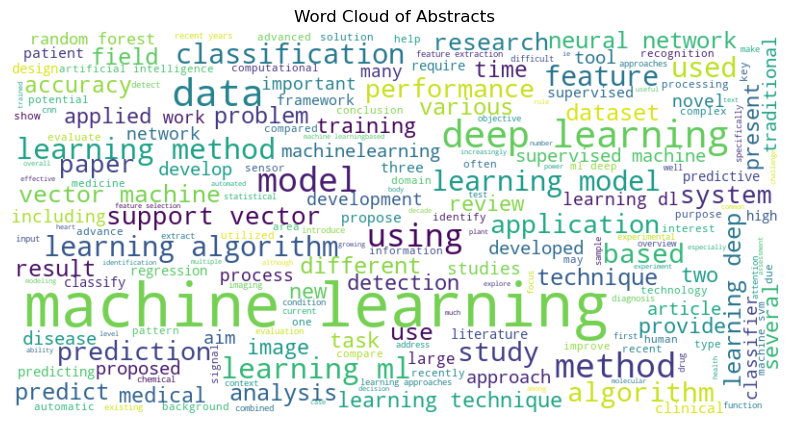

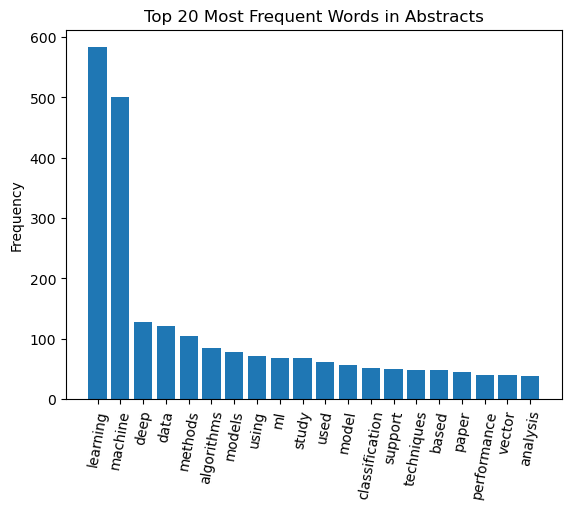

In [43]:
# j'ai combiné tous les tokens
all_tokens = [token for tokens_list in df['Tokens_Abstract'] for token in tokens_list]

# Pour la génération du WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_tokens))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Abstracts")
plt.show()

# Histogramme de distibution
word_counts = Counter(all_tokens)
most_common_words = word_counts.most_common(20)

words, counts = zip(*most_common_words)
plt.bar(words, counts)
plt.xticks(rotation=80)
plt.title("Top 20 Most Frequent Words in Abstracts")
plt.ylabel("Frequency")
plt.show()